In [9]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

stringify = lambda arr: "'" + "','".join(arr) + "'"

# Viz

In [15]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Color definitions
COLOR1 = "#FF0420"
COLOR2 = "#FF6969"
COLOR3 = "#FFCCDD"

# Font size definitions
FONT_SIZE = 15
TITLE_SIZE = 20
SUB_SIZE = 11

# Matplotlib configuration
plt.rcParams.update({
    'figure.figsize': [10, 5],
    'figure.dpi': 300,
    'figure.facecolor': 'white',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'font.family': 'Arial',
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': SUB_SIZE,
    'legend.title_fontsize': SUB_SIZE,
    'figure.titlesize': TITLE_SIZE,
    'figure.titleweight': 'bold',
})

# Query

In [13]:
COLLECTIONS = [
    '8-2,'
    '7-2',
    'op-retrofunding-5',
    'op-retrofunding-4',
    'op-rpgf3',
    'op-rpgf2',
    'op-rpgf1'
]

DEV_ACTIVITY_BY_COHORT = client.to_pandas(f"""

    WITH cte_active_dev_metric AS (
      SELECT metric_id
      FROM metrics_v0
      WHERE metric_name = 'GITHUB_active_developers_monthly'
    ),
    
    cte_project_collection_counts AS (
      SELECT
        project_id,
        COUNT(DISTINCT CASE WHEN collection_name IN ({stringify(COLLECTIONS)}) THEN collection_name END) AS collection_count
      FROM projects_by_collection_v1 AS pbc
      GROUP BY project_id
    )
    
  SELECT
    tm.project_id,
    tm.sample_date,
    tm.amount,
    cc.collection_count
  FROM timeseries_metrics_by_project_v0 AS tm
  JOIN cte_project_collection_counts AS cc ON tm.project_id = cc.project_id
  WHERE tm.metric_id IN (SELECT metric_id FROM cte_active_dev_metric)
     
""")

In [14]:
DEV_ACTIVITY_BY_COHORT

,project_id,sample_date,amount,collection_count
0,9Xqyv+HuPQ+U18OpukRS4SKUxEPRk0KwgvMoF4B43kE=,2022-09-01,2,0
1,YYJ9ctL2bqjOwcI2FJUYWmE3MZo4FY9M+JqSOhNu61c=,2022-09-01,1,0
2,vIuGazJD7gxr+OuFNIUNMLHJwV3ghvniZ8JxtsYF8Jk=,2022-09-01,5,0
3,GGr0qznBTeYaRO9nXIojSszazjrrjqGhecJErR4XJIk=,2022-09-01,5,1
4,YpoeDC2VLaK2bwiwzjZxTrUse6pJ5hh+i2p5BfG+YUc=,2022-09-01,6,0
...,...,...,...,...
75322,qyjK0DPZtk3ivVkGnS6lnLjho2WvHmxtSs1tst8vwvw=,2024-11-01,1,0
75323,BlDNk4kxsizXoIEkvt31dmxysDztXOp5cpS8TRfsXiw=,2024-11-01,3,1
75324,rxbVSISIAekz5R0PiMnBaovVGm5qOzOunV+hkiF7wCg=,2024-11-01,2,2
75325,LyzgDW/+iYbu3p54UBsdm18Fs20pIxzWvElEGW6LdWQ=,2024-11-01,2,0


In [19]:
def growth_rate(monthly_values):
    n = len(monthly_values) - 1
    years = n / 12
    start_value = monthly_values.iloc[0]
    end_value = monthly_values.iloc[-1]
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr

Text(0.0, 1.0, 'Change in developer activity by cohort\n')

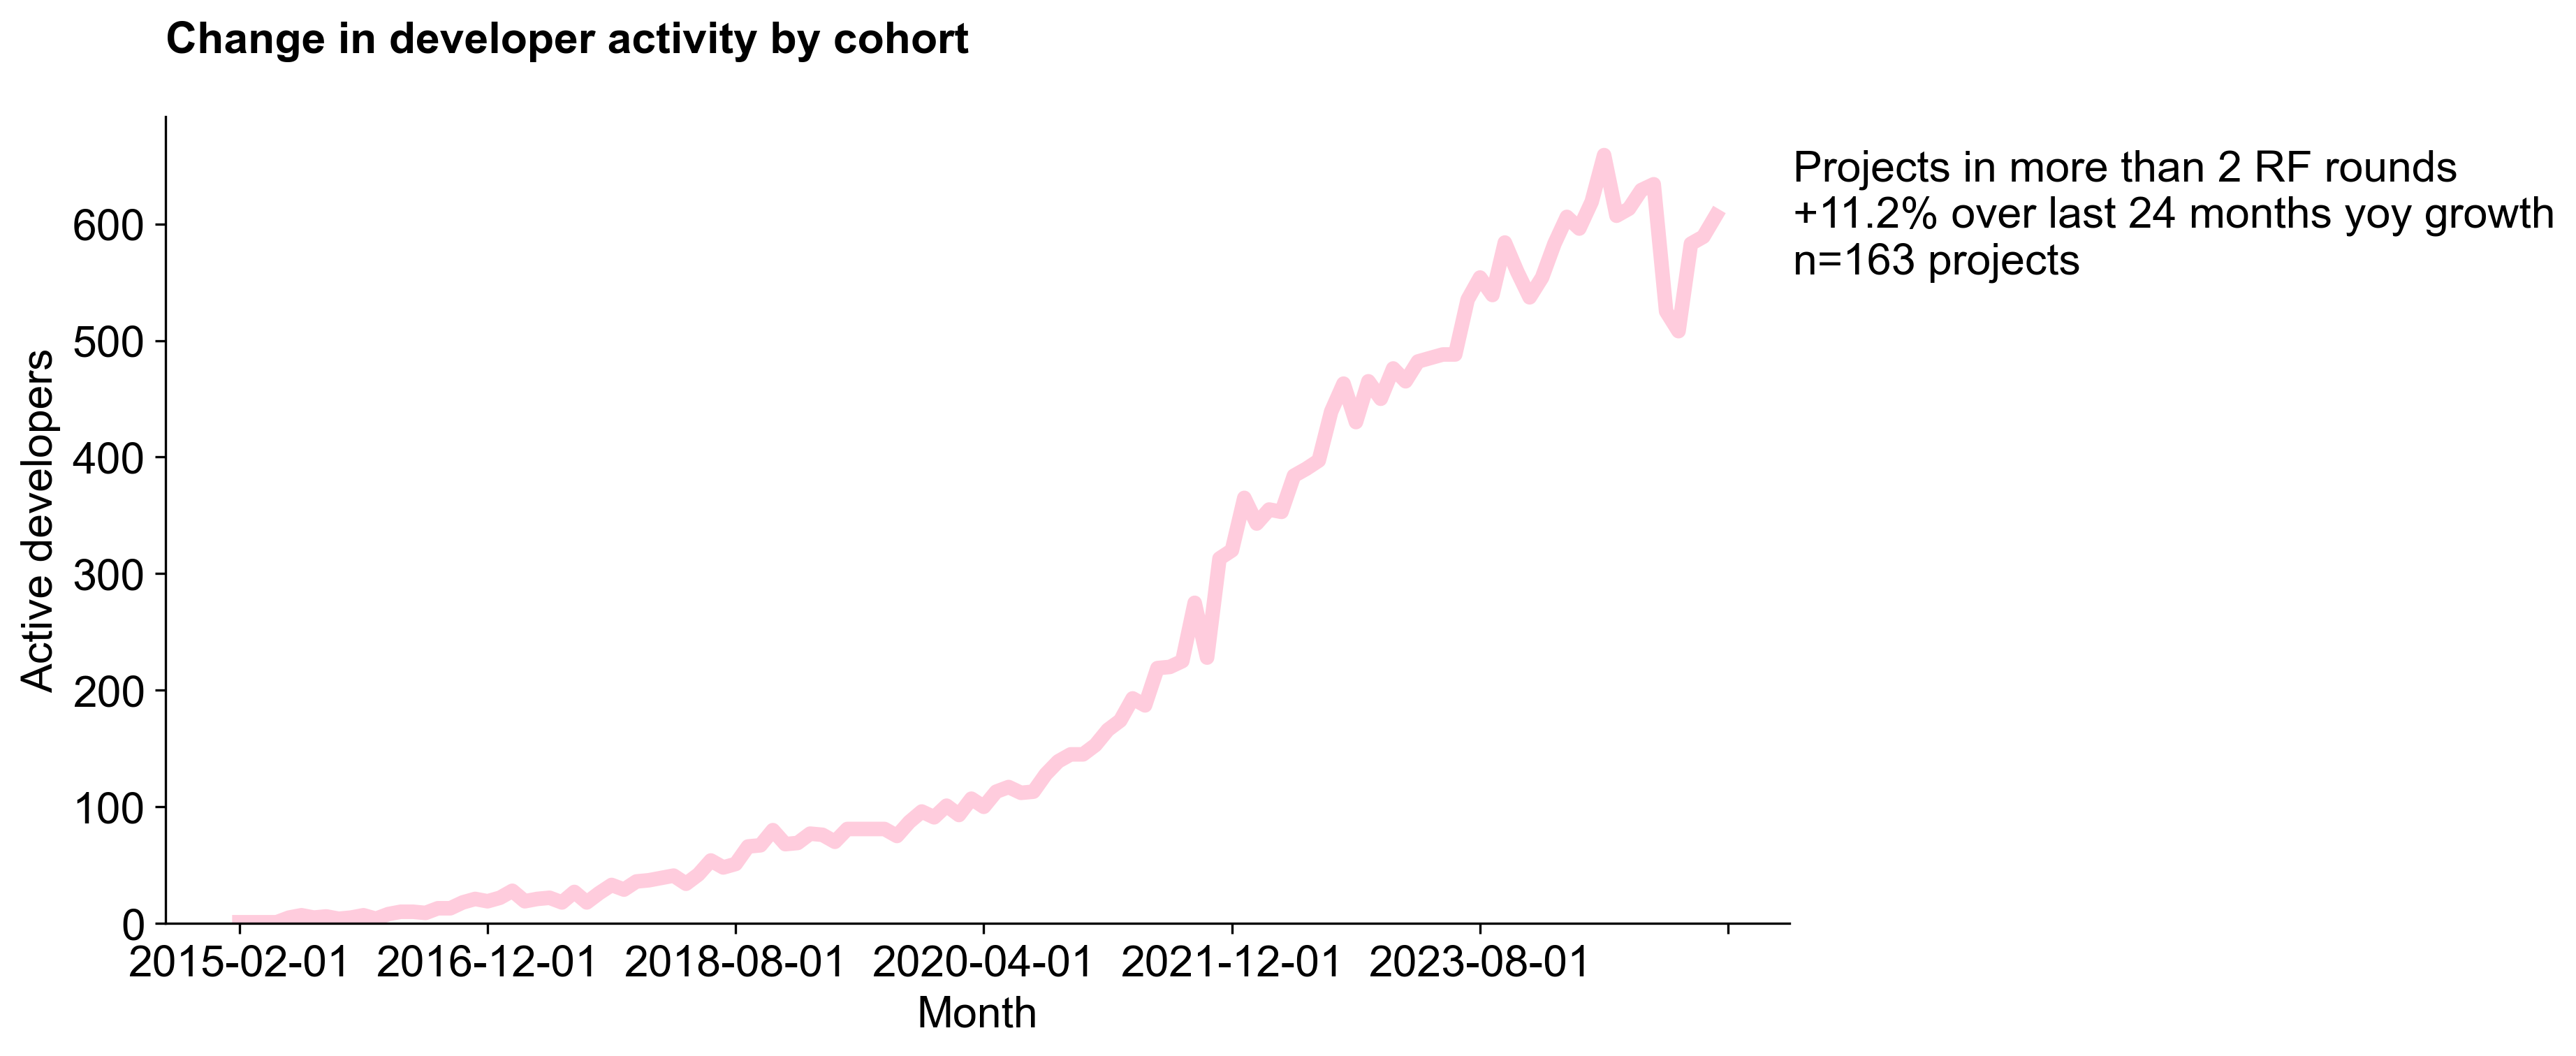

In [30]:
fig, ax = plt.subplots()

ROUNDS = 2
dev_dff = (
    DEV_ACTIVITY_BY_COHORT[DEV_ACTIVITY_BY_COHORT['collection_count']>=ROUNDS]
    .groupby('sample_date')['amount']
    .sum()
)
dev_dff.plot(kind='line', color=COLOR3, lw=5, ax=ax)

label = f'Projects in more than {ROUNDS} RF rounds'
g = growth_rate(dev_dff[-24:-1])
n = DEV_ACTIVITY_BY_COHORT[DEV_ACTIVITY_BY_COHORT['collection_count']>=ROUNDS]['project_id'].nunique()
gstr = f"{g:+.1%} over last 24 months"
label = f"{label}\n{gstr} yoy growth\nn={n} projects"
xmax = ax.get_xlim()[-1] + .25
ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', size=FONT_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity by cohort\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Change in developer activity by cohort\n')

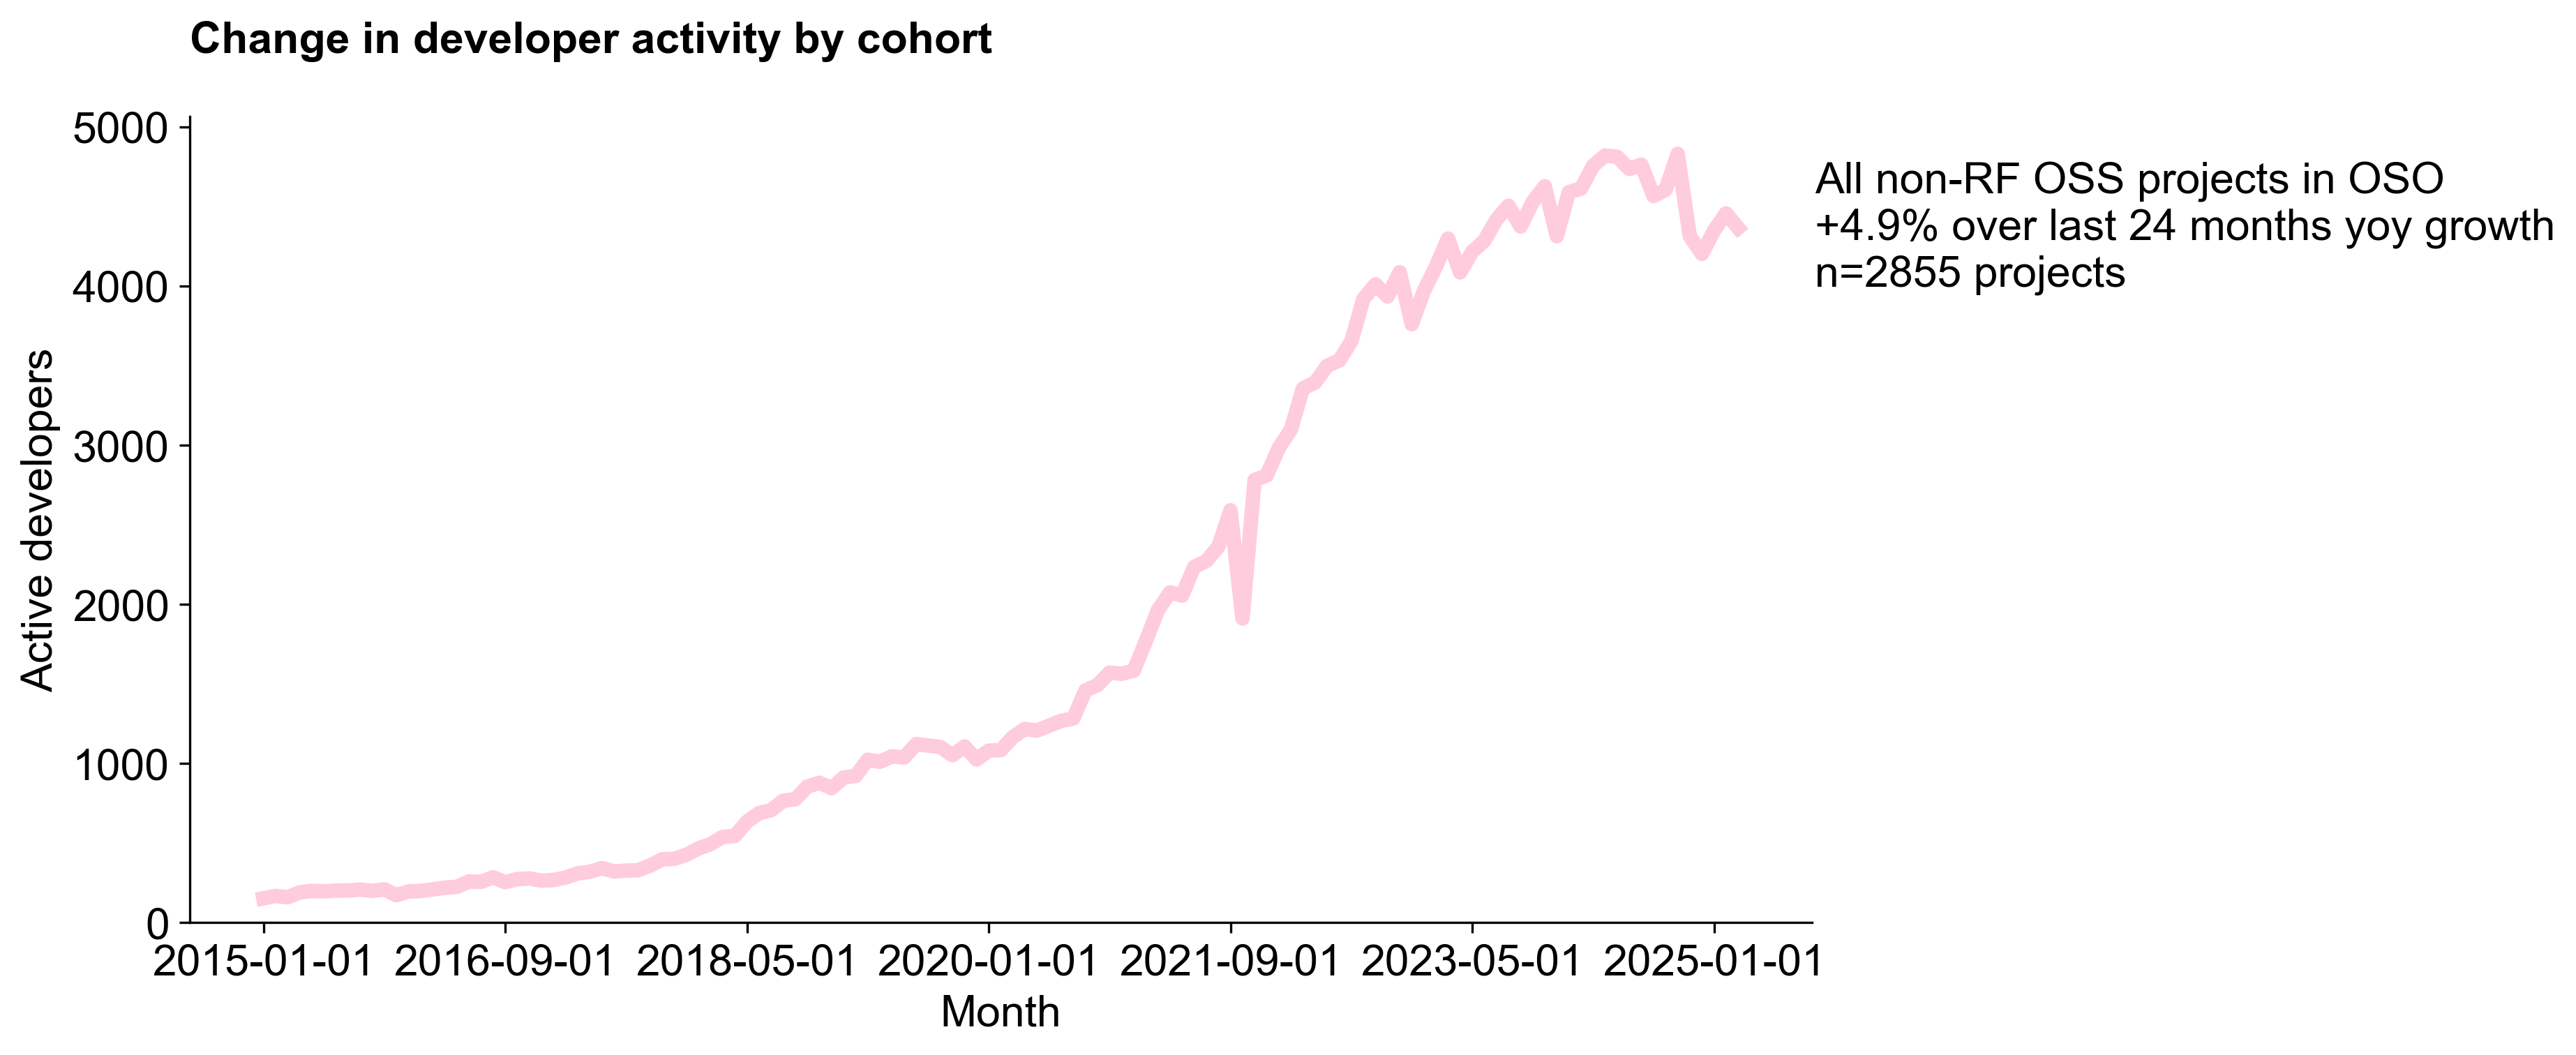

In [32]:
fig, ax = plt.subplots()

ROUNDS = 0
dev_dff = (
    DEV_ACTIVITY_BY_COHORT[DEV_ACTIVITY_BY_COHORT['collection_count']==ROUNDS]
    .groupby('sample_date')['amount']
    .sum()
)
dev_dff.plot(kind='line', color=COLOR3, lw=5, ax=ax)

label = f'All non-RF OSS projects in OSO'
g = growth_rate(dev_dff[-24:-1])
n = DEV_ACTIVITY_BY_COHORT[DEV_ACTIVITY_BY_COHORT['collection_count']==ROUNDS]['project_id'].nunique()
gstr = f"{g:+.1%} over last 24 months"
label = f"{label}\n{gstr} yoy growth\nn={n} projects"
xmax = ax.get_xlim()[-1] + .25
ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', size=FONT_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity by cohort\n", loc='left', weight='bold')